In [2]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.spines as spines

folder = "experiments/"
folder2 = "comp2_experiments/"

# Get results from comp 1 folder
paths = os.listdir(folder)
survey_paths = {path.split("_")[1] : path for path in paths if "survey" in path}
experiment_results_paths = {path.split("_")[1].split('.')[0] : path for path in paths if not "survey" in path}

# Get results from comp 2 folder
paths_comp2 = os.listdir(folder2)
experiment_results_paths_2 = {'2' + path.split("_")[1].split('.')[0] : path for path in paths_comp2 if not "survey" in path}
experiment_results_paths.update(experiment_results_paths_2)

experiment_ids = list(experiment_results_paths.keys())
print(experiment_results_paths)

{'1651173731': 'comp1_1651173731.csv', '1651174140': 'comp1_1651174140.csv', '1651174244': 'comp1_1651174244.csv', '1651174316': 'comp1_1651174316.csv', '1651174376': 'comp1_1651174376.csv', '1651174477': 'comp1_1651174477.csv', '1651174634': 'comp1_1651174634.csv', '1651174729': 'comp1_1651174729.csv', '1651176011': 'comp1_1651176011.csv', '1651176322': 'comp1_1651176322.csv', '1651176556': 'comp1_1651176556.csv', '1651176896': 'comp1_1651176896.csv', '1651177208': 'comp1_1651177208.csv', '1651177349': 'comp1_1651177349.csv', '1651177412': 'comp1_1651177412.csv', '1651177469': 'comp1_1651177469.csv', '1651177572': 'comp1_1651177572.csv', '1651177648': 'comp1_1651177648.csv', '1651177694': 'comp1_1651177694.csv', '1651177751': 'comp1_1651177751.csv', '1651177890': 'comp1_1651177890.csv', '1651178138': 'comp1_1651178138.csv', '1651178210': 'comp1_1651178210.csv', '1651178312': 'comp1_1651178312.csv', '1651178396': 'comp1_1651178396.csv', '1651178451': 'comp1_1651178451.csv', '1651178502

In [3]:
# Put all surveys and results into separate dictionaries
surveys = {}
results = {}
ids = {
    1 : 0,
    2 : 0,
    3 : 0
}
for id in experiment_ids:
    survey = None
    if id in survey_paths:
        survey_path = survey_paths[id]
        df_survey = pd.read_csv('experiments/' + survey_path)
        surveys.update({id : df_survey})
    if id in experiment_ids:
        results_path = experiment_results_paths[id]
        if id[0] == '1':
            df_results = pd.read_csv('experiments/' + results_path)
        elif id[0] == '2':
            df_results = pd.read_csv("comp2_experiments/" + results_path)

        # Count slow, med, fast
        speed = df_results.iloc[0]["dpi_setting"]
        ids[speed] += 1

        # Add a new column for time between circle clicks
        df_results['shifted_time'] = df_results['time_clicked'].transform(lambda x: x.shift(periods=1, fill_value=0))
        shift_time = lambda x: x.time_clicked - x.shifted_time
        df_results['delta_t'] = df_results.apply(shift_time, axis=1)
        df_results = df_results.drop('shifted_time', axis=1)

        
        results.update({id : df_results})
print(ids)


{1: 19, 2: 12, 3: 18}


In [4]:
old_backup = """
### Analysis of results first (then do surveys)

## Do some cleaning of dfs

for id in results.keys():
    # Drop unnamed column

    # TODO Make the time between clicks about differences NOT about position of t

    # TODO compute accuracy % based on distance from radius of circle (if x <= r, 100%; if x > r, r/x)
    f = lambda x: x.circle_radius/x.click_distance_from_circle_center
    results[id]['accuracy'] = results[id].apply(f, axis=1)



## Combine all dfs into one df
all_results_df = pd.concat(results)
all_results_df = all_results_df.drop('Unnamed: 0', axis=1)
print(all_results_df)
"""

In [5]:
### Analysis of results first (then do surveys)

## Combine all dfs into one df
all_results_df = pd.concat(results)

## Do some cleaning of dfs

# Drop unnamed column and problematic entries
all_results_df = all_results_df.drop('Unnamed: 0', axis=1)
all_results_df = all_results_df.drop(('1651174316', 10))

# TODO Make the time between clicks about differences NOT about position of t
#all_results_df[['shifted_time']] = all_results_df[['time_clicked']].transform(lambda x: x.shift(periods=1, fill_value=0))
#shift_time = lambda x: x.time_clicked - x.shifted_time
#all_results_df[['delta_t']] = all_results_df.apply(shift_time, axis=1)
#all_results_df = all_results_df.drop('shifted_time', axis=1)

# TODO compute accuracy % based on distance from radius of circle (if x <= r, 100%; if x > r, r/x)
f = lambda x: (lambda r, c: 1 if r >= c else r/c)(float(x.circle_radius), float(x.click_distance_from_circle_center))
all_results_df[['accuracy']] = all_results_df.apply(f, axis=1)


# Rename "time_clicked" to t
all_results_df[['t']] = all_results_df[['time_clicked']]
all_results_df = all_results_df.drop('time_clicked', axis=1)


all_results_df[['delta_t', "t"]].head(20)

delta_t         t
1651173731 0  1.486618  1.486618
           1  1.484163  2.970781
           2  1.149053  4.119834
           3  1.066986  5.186820
           4  0.773116  5.959936
           5  1.089438  7.049374
           6  0.538733  7.588107
           7  0.355132  7.943239
           8  0.694108  8.637347
           9  0.990430  9.627777
1651174140 0  2.074000  2.074000
           1  1.285695  3.359695
           2  0.891973  4.251669
           3  0.430565  4.682234
           4  0.619025  5.301260
           5  0.734981  6.036240
           6  0.636026  6.672266
           7  0.498812  7.171078
           8  0.596253  7.767331
           9  0.566000  8.333331

In [6]:
# Accuracy and speed readout for all dpi settings
accuracies = []
times = []
for i in [1, 2, 3]:
    columns = ['dpi_setting', 'accuracy', 'delta_t']
    print(f"DPI SETTING {i}")
    dpi_mean_results = all_results_df[columns].query(f"dpi_setting == {i}").mean()
    #print(dpi_mean_results)
    print()
    accuracies.append(dpi_mean_results["accuracy"])
    times.append(dpi_mean_results["delta_t"])

    dpi_results = all_results_df[['dpi_setting']].groupby('dpi_setting')
    print(dpi_results)

DPI SETTING 1

DPI SETTING 2

DPI SETTING 3



[Text(0, -18, '97.6%'), Text(0, -18, '96.2%'), Text(0, -18, '90.2%')]

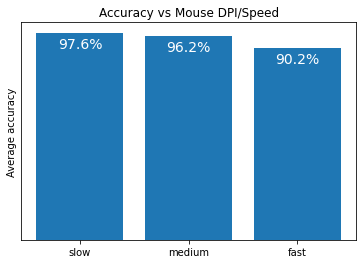

In [7]:

# Plot info
dpis = ["slow", "medium", "fast"]

# Plot accuracies
plt.tick_params(left=False, top=False, labelleft=False)

plt.title("Accuracy vs Mouse DPI/Speed")
plt.ylabel("Average accuracy")
accuracy_labels = [f"{x*100:0.1f}%" for x in accuracies]

accuracy_bar = plt.bar(dpis, accuracies)
plt.bar_label(accuracy_bar, padding=-18, color='w', fontsize=14, labels=accuracy_labels)



[Text(0, -18, '2.4%'), Text(0, -18, '3.8%'), Text(0, -18, '9.8%')]

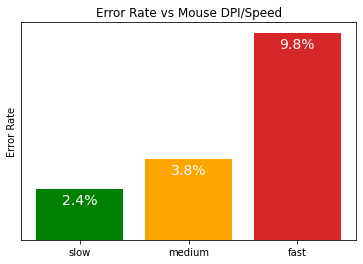

In [8]:
# Plot error rate
plt.title("Error Rate vs Mouse DPI/Speed")
plt.ylabel("Error Rate")
plt.tick_params(left=False, top=False, labelleft=False)
errors = [1-acc for acc in accuracies]
errors_labels = [f"{x*100:0.1f}%" for x in errors]
colors = ['g', 'orange', 'tab:red']
errors_bar = plt.bar(dpis, errors, color=colors)
plt.bar_label(errors_bar, padding=-18, color='w', fontsize=14, labels=errors_labels)


[Text(0, -18, '0.92s'), Text(0, -18, '0.76s'), Text(0, -18, '0.77s')]

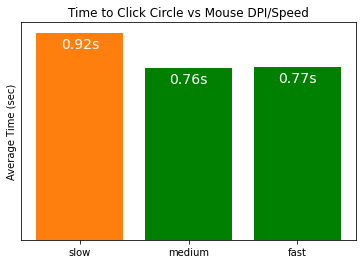

In [9]:
plt.title("Time to Click Circle vs Mouse DPI/Speed")
plt.ylabel("Average Time (sec)")
plt.tick_params(left=False, top=False, labelleft=False)
colors = ['tab:orange', 'green', 'green']
time_labels = [f"{x:0.2f}s" for x in times]
time_bar = plt.bar(dpis, times, color=colors)
plt.bar_label(time_bar, padding=-18, color='w', fontsize=14, labels=time_labels)



[Text(0, -18, '10.89'), Text(0, -18, '13.11'), Text(0, -18, '13.06')]

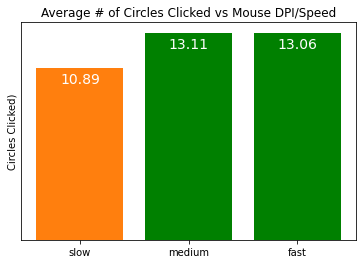

In [10]:
plt.title("Average # of Circles Clicked vs Mouse DPI/Speed")
plt.ylabel("Circles Clicked)")
plt.tick_params(left=False, top=False, labelleft=False)
circles_clicked = [10/t for t in times]
circles_clicked_labels = [f"{x:0.2f}" for x in circles_clicked]
circles_clicked_bar = plt.bar(dpis, circles_clicked, color=colors)
plt.bar_label(circles_clicked_bar, padding=-18, color='w', fontsize=14, labels=circles_clicked_labels)

In [15]:
columns = "dpi_setting computer_no delta_t accuracy".split()
flattened_df = all_results_df.droplevel(0)
flattened_df[columns].head()

,dpi_setting,computer_no,delta_t,accuracy
0,1,1,1.486618,1.0
1,1,1,1.484163,1.0
2,1,1,1.149053,1.0
3,1,1,1.066986,1.0
4,1,1,0.773116,1.0
